# <center> Image Segmentation Project
    
    
---

# Importing libraries

In [1]:
from matplotlib import pyplot as plt  # Displaying images
from skimage.io import imread         # Read the images
import numpy as np                    # Data Handling
import datetime                       # Used in Naming
import math                           # Math operations
import os                             # Directory files

# One Hot Encoded Mask and Dataset Building
from tensorflow.keras.utils import to_categorical, Sequence
import tensorflow as tf
import keras

In [2]:
# Set the root directory paths for images and masks
img_dir = '/kaggle/input/images/render'
mask_dir = '/kaggle/input/images/clean'

# Sort the files in root directories, Create and Store the complete image and mask paths
images = [os.path.join(img_dir, x) for x in sorted(os.listdir(img_dir))]
masks = [os.path.join(mask_dir, x) for x in sorted(os.listdir(mask_dir))]


# First 8000 images to be used for training
X_train = images[:8000]
y_train = masks[:8000]

# Remaining can be used for validation purpose
X_valid = images[8000:-100]
y_valid = masks[8000:-100]

# Save some for testing purpose
X_test = images[-100:]
y_test = masks[-100:]

## Custom Data Generator to prepare the Dataset

In [3]:
# Dataset Pipeline
class LunarDataset(Sequence):

    # Constructor - x_set, y_set, batch_size, dims, classes
    def __init__(self, x_set, y_set, batch_size, dims, classes):
        self.x = x_set
        self.y = y_set
        self.batch_size = batch_size
        self.img_height, self.img_width = dims
        self.classes = classes

    # Number of Batches --> total length of images / batch size --> Ceil operation
    def __len__(self):
        return math.ceil(len(self.x)/self.batch_size)

    # Fetch the data in batches by using iter and next opertions (allows you to use slice and indexing)
    def __getitem__(self, idx):
        # Get start and end indexes to create a batch of batch size
        start_index = idx * self.batch_size
        end_index = (idx + 1) * self.batch_size

        # Prepare X and y batches
        batch_x = self.x[start_index : end_index]
        batch_y = self.y[start_index : end_index]

        # Empty lists to append preprocessed Images and Masks Array from the for loop
        xtr = []
        ytr = []

        # For every  image and mask in one batch do the following preprocessing
        for idx, (filename_x, filename_y) in enumerate(zip(batch_x, batch_y)):
            
            # Image preprocessing
            img = imread(filename_x)[:self.img_height, :self.img_width, :]/255.0
            img = img.astype(np.float32)
            xtr.append(img)
            
            # Mask preprocessing
            mask = imread(filename_y, as_gray=True)[:self.img_height, :self.img_width]//0.07 # 0, 1, 3, 10
            mask[mask == 3] = 2
            mask[mask == 10] = 3
            mask = to_categorical(mask, num_classes = self.classes)
            ytr.append(mask)
            
        # Convert list to arrays ensuring the dtype of mask is also float32
        xtr = np.array(xtr)
        ytr = np.array(ytr).astype(np.float32)

        # Return the preprocessed batch of images and respective mask as output
        return xtr, ytr

In [4]:
# Parameters
batch_size = 16
dims = (480, 480)
num_classes = 4

# Dataset Creation
train_dataset = LunarDataset(X_train, y_train, batch_size, dims, num_classes)
valid_dataset = LunarDataset(X_valid, y_valid, batch_size, dims, num_classes)

## Let's visualize our masks

In [5]:
# Taking a sample batch from train_dataset
batch = next(iter(train_dataset)) # Batch Size, Height, Width, Channels (Images, Masks)

# Check the shape of batch created --> Images and Masks
print(batch[0].shape) # 16 images in a batch
print(batch[1].shape) # 16 respective masks in a batch

(16, 480, 480, 3)
(16, 480, 480, 4)


In [6]:
# Get the mask
sample = batch[1][1]

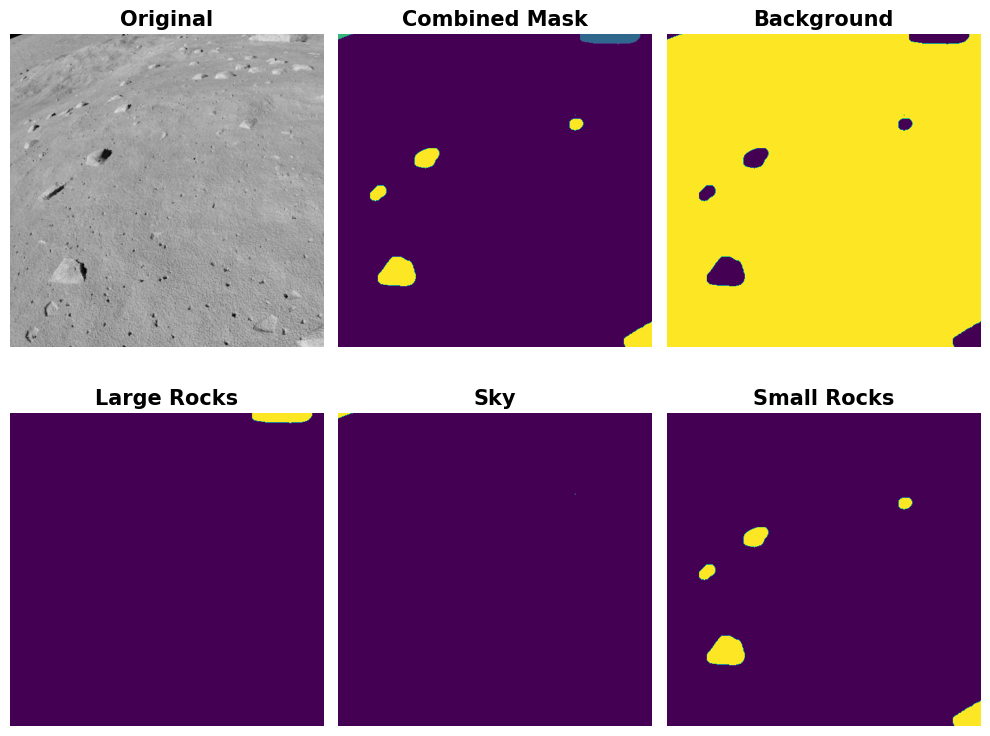

In [7]:
# Creating Subplot for better visualization
fig, ((a1, a2, a3), (a4, a5, a6)) = plt.subplots(2, 3, figsize = (10, 8))

# For different axes and titles
for i, (ax,title) in enumerate(zip((a1, a2, a3, a4, a5, a6),
                                   ('Original', 'Combined Mask', 'Background', 'Large Rocks', 'Sky', 'Small Rocks'))):
    if i == 0:
        ax.imshow(batch[0][1])                    # Second Image in the batch (Original)
    elif i == 1:
        ax.imshow(np.argmax(sample, axis=-1))     # Converts One Hot encoded mask to Integer Encoded Mask (single channel)
    else:
        ax.imshow(sample[:, :, i-2])              # Channel Wise Output from Mask

    # Set Title and turn off the axis
    ax.set_title(title, fontsize=15, weight='bold')
    ax.axis('off')

# Adjust Layout and Display the Subplot
plt.tight_layout()
plt.show()

segmentation models

In [8]:
!pip install segmentation_models

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [9]:
os.environ["SM_FRAMEWORK"] = "tf.keras" # Set the environment variable SM_FRAMEWORK to "tf.keras"
import segmentation_models as sm        # It will import without any errors if env variable is set properly
sm.set_framework('tf.keras')            # Use segmentation_models library and set the framework to TensorFlow's Keras

Segmentation Models: using `tf.keras` framework.


In [10]:
tf.keras.backend.set_image_data_format('channels_last')

**UNet Model**

In [11]:
# parameters
BACKBONE = 'resnet50'
input_shape = (480, 480, 3)
n_classes = 4
activation = 'softmax'

model = sm.Unet(backbone_name = BACKBONE,
               input_shape = input_shape,
               classes = n_classes,
               activation = activation,
                 encoder_weights = 'imagenet',
                 encoder_freeze = True)

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ data (InputLayer)   │ (None, 480, 480,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_data             │ (None, 480, 480,  │          9 │ data[0][0]        │
│ (BatchNormalizatio… │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 486, 486,  │          0 │ bn_data[0][0]     │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv0 (Conv2D)      │ (None, 240, 240,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn0                 │ (None, 240, 240,  │        256 │ conv0[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu0 (Activation)  │ (None, 240, 240,  │          0 │ bn0[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 242, 242,  │          0 │ relu0[0][0]       │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pooling0            │ (None, 120, 120,  │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn1    │ (None, 120, 120,  │        256 │ pooling0[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu1  │ (None, 120, 120,  │          0 │ stage1_unit1_bn1… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv1  │ (None, 120, 120,  │      4,096 │ stage1_unit1_rel… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn2    │ (None, 120, 120,  │        256 │ stage1_unit1_con… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu2  │ (None, 120, 120,  │          0 │ stage1_unit1_bn2… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_2    │ (None, 122, 122,  │          0 │ stage1_unit1_rel… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv2  │ (None, 120, 120,  │     36,864 │ zero_padding2d_2… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn3    │ (None, 120, 120,  │        256 │ stage1_unit1_con… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu3  │ (None, 120, 120,  │          0 │ stage1_unit1_bn3

 Total params: 32,561,549 (124.21 MB)

 Trainable params: 9,059,079 (34.56 MB)

 Non-trainable params: 23,502,470 (89.65 MB)

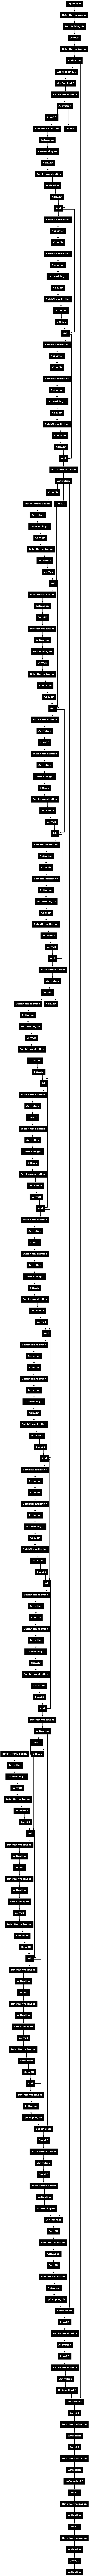

In [12]:
from tensorflow.keras.utils import plot_model
plot_model(model, 'unet_resnet50.png')

**COMPILATION**

In [13]:
# Hyperparameters
lr = 1e-3
batch_size = 16
epochs = 8

metrics = [sm.metrics.IOUScore(threshold=0.7)]

#defining jaccard loss

import tensorflow as tf
def jaccard_loss(y_true, y_pred):
    # Flatten the labels and predictions
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    
    # Intersection over Union (IoU)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    sum_ = tf.reduce_sum(y_true_f + y_pred_f)
    jac = (intersection + 1e-15) / (sum_ - intersection + 1e-15)
    
    # Jaccard Loss
    return 1 - jac

model.compile(loss = jaccard_loss,
              optimizer = tf.keras.optimizers.Adam(lr),
              metrics = metrics)

train_steps = len(X_train)//batch_size
valid_steps = len(X_valid)//batch_size

# callbacks
callbacks = [
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor = 'val_iou_score',
            mode = 'max',
            patience = 2,
            factor = 0.1,
            verbose = 1,
            min_lr = 1e-6
        ),

        tf.keras.callbacks.EarlyStopping(
            monitor = 'val_iou_score',
            patience = 3,
            mode = 'max',
            verbose = 1
        )
    ]

In [21]:
with open('custom_module.py', 'w') as file:
    file.write('import tensorflow as tf\n\n')
    file.write('def jaccard_loss(y_true, y_pred, smooth=1e-6):\n')
    file.write('    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])\n')
    file.write('    sum_ = tf.reduce_sum(y_true + y_pred, axis=[1, 2, 3])\n')
    file.write('    jac = (intersection + smooth) / (sum_ - intersection + smooth)\n')
    file.write('    return 1 - jac\n')

**Training the model**

In [14]:
# fit
model_history = model.fit(train_dataset,
        validation_data=valid_dataset,
        epochs=epochs,
        callbacks=callbacks,
    )

Epoch 1/8


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1725116909.702881     447 service.cc:145] XLA service 0x789c580047e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725116909.702939     447 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1725116909.702944     447 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1725116989.199420     447 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_reduce_window_fusion_1', 16 bytes spill stores, 16 bytes spill loads

I0000 00:00:172511

500/500 ━━━━━━━━━━━━━━━━━━━━ 668s 1s/step - iou_score: 0.4321 - loss: 0.1864 - val_iou_score: 0.3668 - val_loss: 0.2270 - learning_rate: 0.0010
Epoch 2/8
500/500 ━━━━━━━━━━━━━━━━━━━━ 523s 1s/step - iou_score: 0.6362 - loss: 0.0756 - val_iou_score: 0.5101 - val_loss: 0.1388 - learning_rate: 0.0010
Epoch 3/8
500/500 ━━━━━━━━━━━━━━━━━━━━ 524s 1s/step - iou_score: 0.7751 - loss: 0.0510 - val_iou_score: 0.7620 - val_loss: 0.0564 - learning_rate: 0.0010
Epoch 4/8
500/500 ━━━━━━━━━━━━━━━━━━━━ 525s 1s/step - iou_score: 0.8038 - loss: 0.0450 - val_iou_score: 0.7278 - val_loss: 0.0802 - learning_rate: 0.0010
Epoch 5/8
500/500 ━━━━━━━━━━━━━━━━━━━━ 535s 1s/step - iou_score: 0.8060 - loss: 0.0465 - val_iou_score: 0.8067 - val_loss: 0.0458 - learning_rate: 0.0010
Epoch 6/8
500/500 ━━━━━━━━━━━━━━━━━━━━ 535s 1s/step - iou_score: 0.8170 - loss: 0.0429 - val_iou_score: 0.8140 - val_loss: 0.0444 - learning_rate: 0.0010
Epoch 7/8
500/500 ━━━━━━━━━━━━━━━━━━━━ 530s 1s/step - iou_score: 0.8212 - loss: 0.0416

**PREDICTION**

In [15]:
# function to predict result
def predict_image(img_path, mask_path, model):
    ## Basic Setup
    H = 480
    W = 480
    num_classes = 4

    ## Read Images and Preprocess
    img = imread(img_path)
    img = img[:W, :H]
    img = img / 255.0
    img = img.astype(np.float32)

    ## Read mask and Preprocess
    mask = imread(mask_path, as_gray = True)
    mask = mask[:W, :H]

    ## Prediction mask and Postprocess
    pred_mask = model.predict(np.expand_dims(img, axis=0))
    pred_mask = np.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[0]


    ## Calculating IOU score
    inter = np.logical_and(mask, pred_mask)
    union = np.logical_or(mask, pred_mask)

    iou = inter.sum()/union.sum()

    return img, mask, pred_mask, iou

In [16]:
X_test[0], y_test[0]

('/kaggle/input/images/render/render9667.png',
 '/kaggle/input/images/clean/clean9667.png')

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


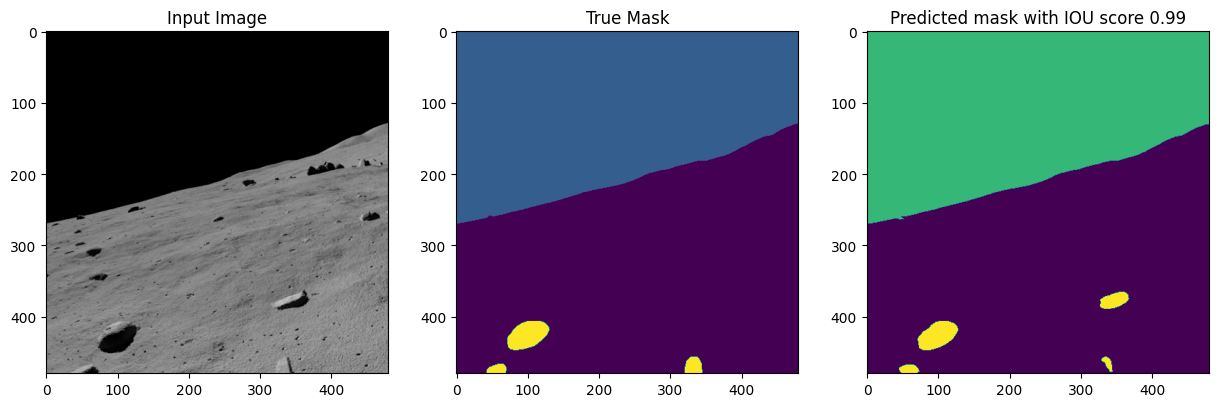

In [17]:
index_test = 0
img_path = X_test[index_test]
mask_path = y_test[index_test]

img, mask, pred_mask, iou = predict_image(img_path, mask_path, model)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (15, 10))

ax1.set_title("Input Image")
ax1.imshow(img)

ax2.set_title("True Mask")
ax2.imshow(mask)

ax3.set_title("Predicted mask with IOU score %.2f"%(iou))
ax3.imshow(pred_mask)

plt.show()

In [18]:
from tensorflow.keras.models import load_model, save_model

In [19]:
# Save the Model
save_model(model, 'LunarModel.h5')

In [22]:
from tensorflow.keras.models import load_model
from custom_module import jaccard_loss  # Import the custom Jaccard loss function

# Load the model with the custom Jaccard loss function
loaded_model = load_model('/kaggle/working/LunarModel.h5',  custom_objects={'jaccard_loss': jaccard_loss})
_, _, _, iou_score = predict_image(img_path, mask_path, loaded_model)
print(iou_score)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
0.9868477041507099


In [23]:
import pandas as pd
import numpy as np

In [25]:
data = [
    [ 'Loss = efficientnetb0', 0.78, 0.984],
    [ 'Learning_Rate = 1e-5', 0.65, 0.87],
    [ 'Loss = resnet50', 0.81, 0.985],
    [ 'Learning_Rate = 1e-3', 0.80, 0.971],
    [ 'IOU Threshold = 0.7', 0.8297, 0.9868]
]

columns = ['Change Made', 'Train IOU Score', 'Test IOU Score']

df = pd.DataFrame(data, columns=columns)
print(df)


             Change Made  Train IOU Score  Test IOU Score
0  Loss = efficientnetb0           0.7800          0.9840
1   Learning_Rate = 1e-5           0.6500          0.8700
2        Loss = resnet50           0.8100          0.9850
3   Learning_Rate = 1e-3           0.8000          0.9710
4    IOU Threshold = 0.7           0.8297          0.9868
